# Gender/Age Bias for Movie Ratings Using AIF360

## Import Statements

In [1]:
# !pip uninstall -y numpy

In [2]:
# !pip install numpy

In [3]:
!pip install scikit-surprise

In [4]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import dateutil.parser
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
# from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile

In [5]:
#Install AIF360
!pip install 'aif360'

ERROR: Invalid requirement: "'aif360'"


In [6]:
# Install TensorFlow
!pip install 'tensorflow==2.6.0'

ERROR: Invalid requirement: "'tensorflow==2.6.0'"


In [7]:
pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[LawSchoolGPA]'"


In [8]:
pip install --upgrade tensorflow aif360

  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install protobuf==3.19.0

  Using cached protobuf-3.19.0-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 3.19.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.0 which is incompatible.


In [10]:
pip install 'aif360[AdversarialDebiasing]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[AdversarialDebiasing]'"


In [11]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## Reading File Path

In [12]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Users File
users_file = os.path.join(extract_path, "users.dat")
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_df = pd.read_csv(users_file, sep="::", engine="python", header=None, names=users_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

In [13]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

In [14]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


## Combine Datasets

In [15]:
import re

# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


In [16]:
# Filter to get titles that are only associated with movies

titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10491987,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10492014,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10492026,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10492036,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [17]:
# Merge datasets using Title of movie and year

movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids

,MovieID,Title,Genres,Year,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3948,Meet the Parents,Comedy,2000,tt0212338,movie,Meet the Parents,Meet the Parents,0,2000,\N,108,"Comedy,Romance"
3896,3949,Requiem for a Dream,Drama,2000,tt0180093,movie,Requiem for a Dream,Requiem for a Dream,0,2000,\N,102,Drama
3897,3950,Tigerland,Drama,2000,tt0170691,movie,Tigerland,Tigerland,0,2000,\N,101,"Drama,War"
3898,3951,Two Family House,Drama,2000,tt0202641,movie,Two Family House,Two Family House,0,2000,\N,108,"Comedy,Drama,Romance"


In [18]:
# Find gender of each movie identifier associated with the director

genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

In [19]:
# Combine datasets based on movie identifier 

merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'male_count', 'gender', 'name', 'female_count']]
merged_df

,MovieID,Title,Genres,Year,male_count,gender,name,female_count
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,11.0,male,Joe Johnston,0.0
2,3,Grumpier Old Men,Comedy|Romance,1995,3.0,male,Howard Deutch,0.0
3,4,Waiting to Exhale,Comedy|Drama,1995,116.0,male,Forest Whitaker,5.0
4,5,Father of the Bride Part II,Comedy,1995,2.0,male,Charles Shyer,0.0
...,...,...,...,...,...,...,...,...
4075,3948,Meet the Parents,Comedy,2000,8.0,male,Jay Roach,0.0
4076,3949,Requiem for a Dream,Drama,2000,33.0,male,Darren Aronofsky,3.0
4077,3950,Tigerland,Drama,2000,24.0,male,Joel Schumacher,3.0
4078,3951,Two Family House,Drama,2000,NaN,NaN,NaN,NaN


## Checking for Null Values for Each Dataframe

In [20]:
# Check for null values in merged movies dataset
merged_df.isnull().sum()

MovieID            0
Title              0
Genres             0
Year               0
male_count      2298
gender          2298
name            2298
female_count    2298
dtype: int64

In [21]:
# Check for null values in Ratings file
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [22]:
# Check for null values in Users file
users_df.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [23]:
# Check for null values in Movies file

movies_df.isnull().sum()

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

## Movies EDA

In [24]:
%matplotlib inline

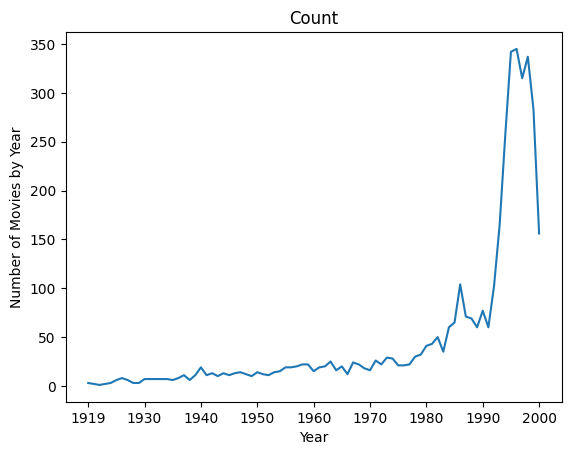

In [25]:
# Number of Movies in dataset by Year

movies_df['Year'].value_counts().sort_index().plot()
plt.ylabel('Number of Movies by Year')
plt.xlabel('Year')
plt.title('Count')
plt.show()

## Merged Dataset EDA

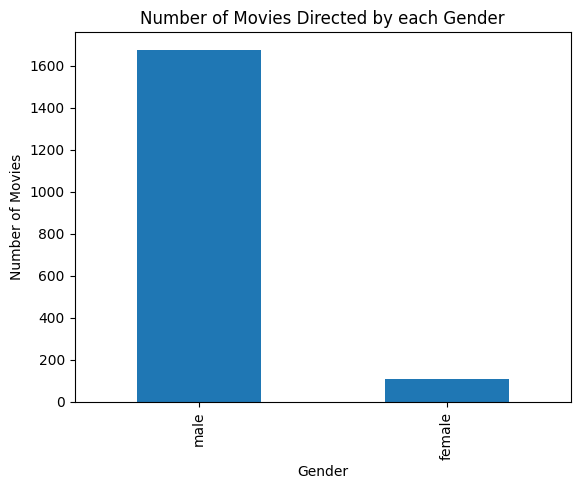

In [26]:
# Number of movies in dataset directed by each gender

merged_df['gender'].value_counts().plot(kind='bar')
plt.ylabel('Number of Movies')
plt.xlabel('Gender')
plt.title('Number of Movies Directed by each Gender')
plt.show()

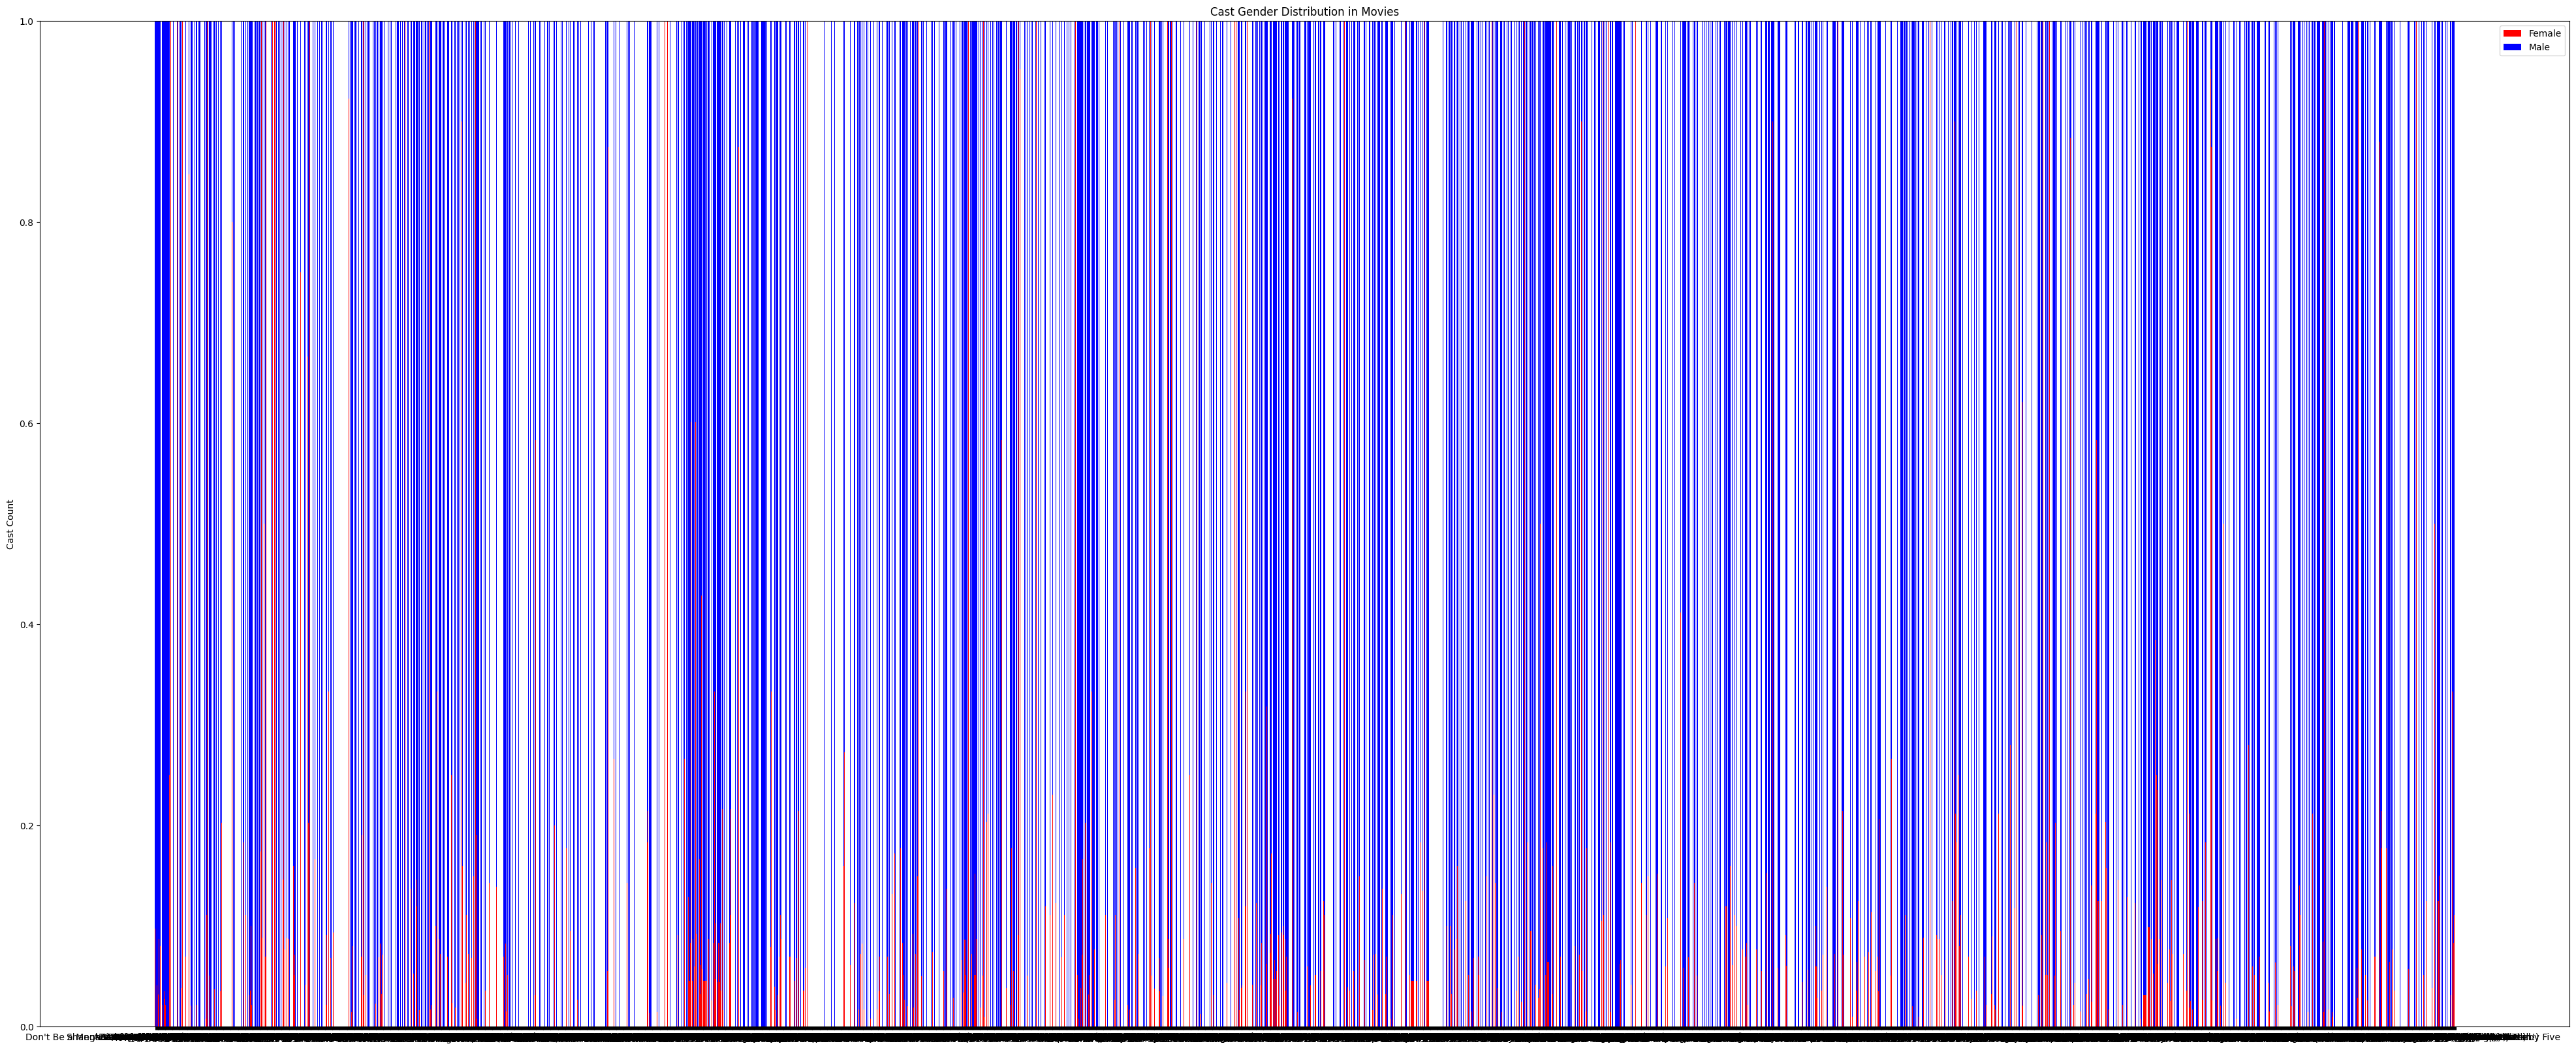

In [27]:
# Proportion of gender in cast of every movie 

plt.figure(figsize=(50, 20))
plt.bar(merged_df['Title'], merged_df['female_count'] / (merged_df['female_count'] + merged_df['male_count']), label='Female', color='red', width=1)
plt.bar(merged_df['Title'], merged_df['male_count'] / (merged_df['female_count'] + merged_df['male_count']), bottom=merged_df['female_count'] / (merged_df['female_count'] + merged_df['male_count']), label='Male', color='blue', width=1)

plt.ylabel('Cast Count')
plt.title('Cast Gender Distribution in Movies')
plt.legend()
plt.show()

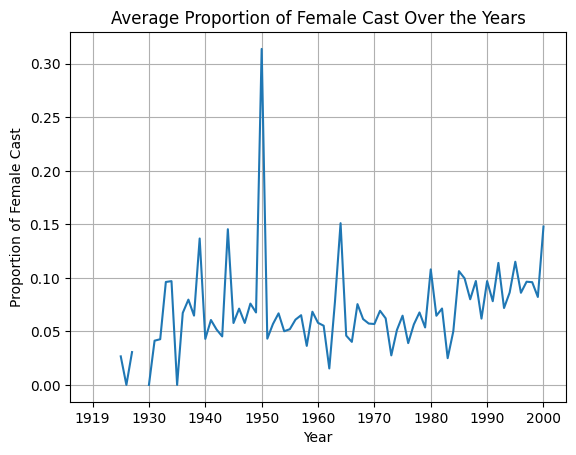

In [28]:
# Average Proportion of Female Cast by year

years = merged_df.groupby('Year')[['female_count', 'male_count']].sum()

(years['female_count'] / (years['female_count'] + years['male_count'])).plot()

plt.title('Average Proportion of Female Cast Over the Years')
plt.xlabel('Year')
plt.ylabel('Proportion of Female Cast')
plt.grid(True)
plt.show()

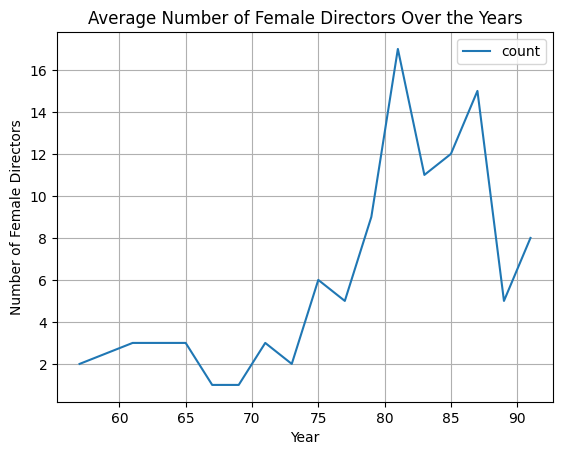

In [29]:
# Average number of Female directors by year

dir_gender_by_year = merged_df.groupby('Year')['gender'].value_counts().sort_index().reset_index()

dir_gender_by_year[dir_gender_by_year['gender'] == 'female'].plot()
plt.title('Average Number of Female Directors Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Female Directors')
plt.grid(True)
plt.show()

## Ratings Dataframe EDA

Text(0, 0.5, 'Count')

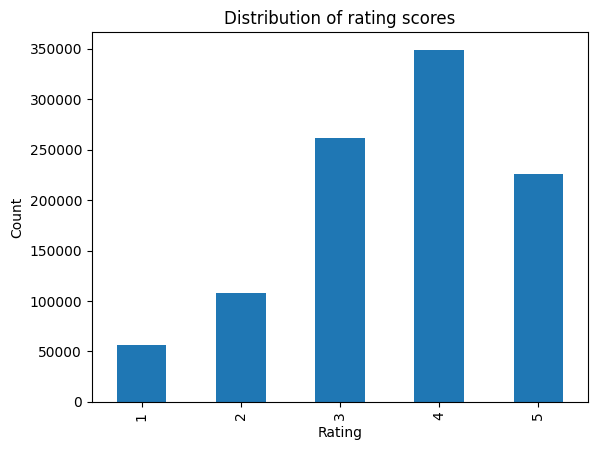

In [30]:
# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating scores')
plt.ylabel('Count')

# There do not appear to be any placeholders for missing vals
# Most ratings are 4 stars, the least amount of ratings are 1 star

Text(0, 0.5, 'Count')

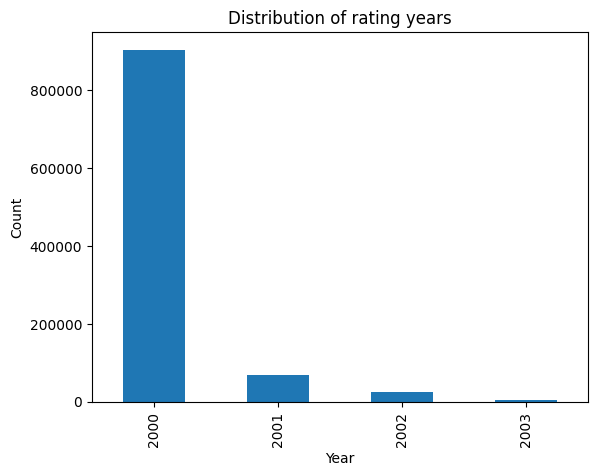

In [31]:
# Convert Timestamp col to datetime objects for visualizations
datetime = pd.to_datetime(ratings_df['Timestamp'], unit='s')

# Plot year of rating
datetime.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating years')
plt.xlabel('Year')
plt.ylabel('Count')

# Almost all ratings are from 2000

Text(0, 0.5, 'Count')

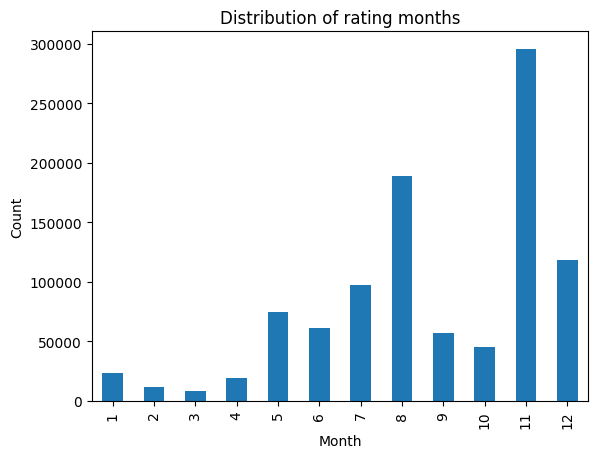

In [32]:
# Plot months of rating
datetime.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most ratings are from November

Text(0, 0.5, 'Count')

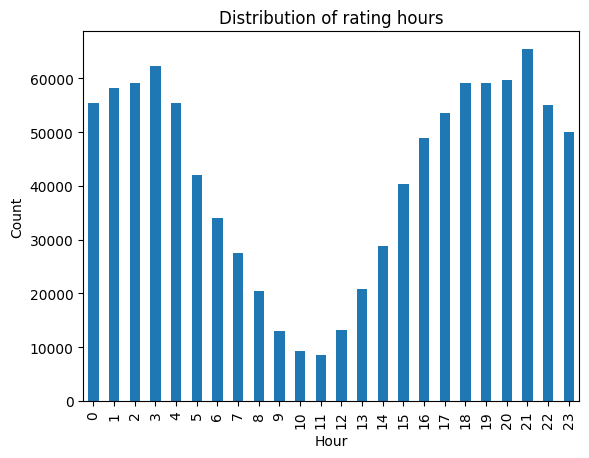

In [33]:
# Plot hour of rating
datetime.dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating hours')
plt.xlabel('Hour')
plt.ylabel('Count')

# Most ratings happen at the beginning of the day or the end, as that's where peaks happen.

In [34]:
# There do not appear to be any placeholders for null values
ratings_df['UserID'].min(), ratings_df['UserID'].max()

(1, 6040)

In [35]:
# Top 5 user IDs who left the most ratings
ratings_df['UserID'].value_counts()[:5]

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [36]:
# There do not appear to be any placeholders for null values
ratings_df['MovieID'].min(), ratings_df['MovieID'].max()

(1, 3952)

## Users EDA

Text(0, 0.5, 'Count')

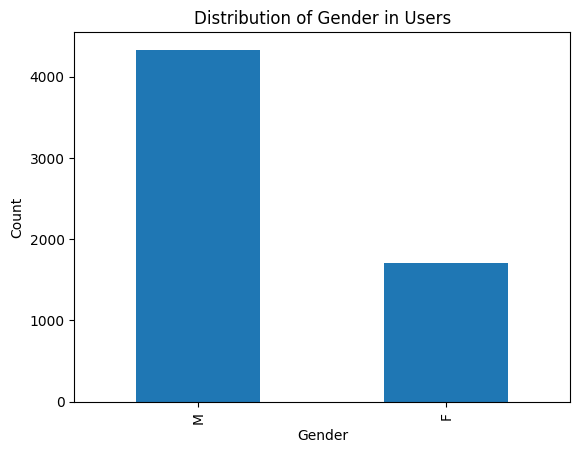

In [37]:
# Distribution of Gender in Users
users_df['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender in Users')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

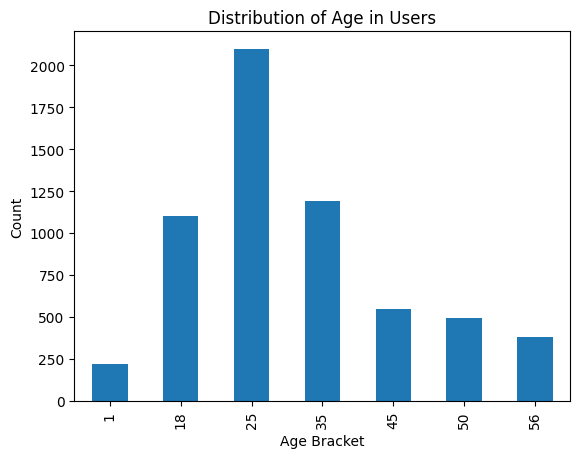

In [38]:
# Distribution of Age in Users
users_df['Age'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Age in Users')
plt.xlabel('Age Bracket')
plt.ylabel('Count')

## User, Movie, Rating Merge

In [39]:
Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID')
Ratings_and_Movies

,MovieID,Title,Genres,Year,male_count,gender,name,female_count,Rating,UserID
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,1
1,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,6
2,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,8
3,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,9
4,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,10
...,...,...,...,...,...,...,...,...,...,...
1086284,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5812
1086285,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,3,5831
1086286,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5837
1086287,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,1,5927


In [40]:
users_df.rename(columns={'Rating': 'User_Rating','Gender': 'User_Gender', 'Age': 'User_Age', 'Occupation': 'User_Occupation', 'Zip-code': 'User_Zip-code'}, inplace=True)

Ratings_and_Movies = pd.merge(Ratings_and_Movies, users_df[['UserID', 'User_Gender', 'User_Age', 'User_Occupation', 'User_Zip-code']], on='UserID')

Ratings_and_Movies.rename(columns={'Rating': 'User_Rating'}, inplace=True)

Ratings_and_Movies

,MovieID,Title,Genres,Year,male_count,gender,name,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation,User_Zip-code
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,1,F,1,10,48067
1,48,Pocahontas,Animation|Children's|Musical|Romance,1995,3.0,male,Mike Gabriel,0.0,5,1,F,1,10,48067
2,48,Pocahontas,Animation|Children's|Musical|Romance,1995,10.0,male,Eric Goldberg,0.0,5,1,F,1,10,48067
3,48,Pocahontas,Animation|Children's|Musical|Romance,1995,NaN,NaN,NaN,NaN,5,1,F,1,10,48067
4,150,Apollo 13,Drama,1995,58.0,male,Ron Howard,13.0,5,1,F,1,10,48067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,Rules of Engagement,Drama|Thriller,2000,61.0,male,William Friedkin,0.0,4,5727,M,25,4,92843
1086285,3535,American Psycho,Comedy|Horror|Thriller,2000,1.0,female,Mary Harron,7.0,2,5727,M,25,4,92843
1086286,3536,Keeping the Faith,Comedy|Romance,2000,112.0,male,Edward Norton,3.0,5,5727,M,25,4,92843
1086287,3555,U-571,Action|Thriller,2000,7.0,male,Jonathan Mostow,7.0,3,5727,M,25,4,92843


In [41]:
Ratings_and_Movies['gender'] = Ratings_and_Movies['gender'].replace({'female': 0, 'male': 1})
Ratings_and_Movies['User_Gender'] = Ratings_and_Movies['User_Gender'].replace({'F': 0, 'M': 1})

In [42]:
# Split the genres column into a list of genres
Ratings_and_Movies['Genres'] = Ratings_and_Movies['Genres'].str.split('|')

# Create a list of unique genres
unique_genres = set(genre for genres_list in Ratings_and_Movies['Genres'] for genre in genres_list)

# Create binary columns for each genre and initialize them with zeros
for genre in unique_genres:
     Ratings_and_Movies[genre] = 0

# Update the binary columns with 1 if the genre is present in the list
for index, row in Ratings_and_Movies.iterrows():
     for genre in row['Genres']:
         Ratings_and_Movies.at[index, genre] = 1

# Drop the original genres column
df = Ratings_and_Movies.drop('Genres', axis=1)

Ratings_and_Movies

,MovieID,Title,Genres,Year,male_count,gender,name,female_count,User_Rating,UserID,...,Fantasy,Thriller,Documentary,Horror,Action,Children's,Drama,Western,Romance,Adventure
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,37.0,1.0,John Lasseter,4.0,5,1,...,0,0,0,0,0,1,0,0,0,0
1,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,3.0,1.0,Mike Gabriel,0.0,5,1,...,0,0,0,0,0,1,0,0,1,0
2,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,10.0,1.0,Eric Goldberg,0.0,5,1,...,0,0,0,0,0,1,0,0,1,0
3,48,Pocahontas,"[Animation, Children's, Musical, Romance]",1995,NaN,NaN,NaN,NaN,5,1,...,0,0,0,0,0,1,0,0,1,0
4,150,Apollo 13,[Drama],1995,58.0,1.0,Ron Howard,13.0,5,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,Rules of Engagement,"[Drama, Thriller]",2000,61.0,1.0,William Friedkin,0.0,4,5727,...,0,1,0,0,0,0,1,0,0,0
1086285,3535,American Psycho,"[Comedy, Horror, Thriller]",2000,1.0,0.0,Mary Harron,7.0,2,5727,...,0,1,0,1,0,0,0,0,0,0
1086286,3536,Keeping the Faith,"[Comedy, Romance]",2000,112.0,1.0,Edward Norton,3.0,5,5727,...,0,0,0,0,0,0,0,0,1,0
1086287,3555,U-571,"[Action, Thriller]",2000,7.0,1.0,Jonathan Mostow,7.0,3,5727,...,0,1,0,0,1,0,0,0,0,0


In [47]:
zip_code_dummies = pd.get_dummies(Ratings_and_Movies['User_Zip-code'], prefix='Zip')

# Concatenate the one-hot encoded zip codes with the original DataFrame
df = pd.concat([Ratings_and_Movies, zip_code_dummies], axis=1)

# Drop the original zip code column as it's no longer needed
df = df.drop('User_Zip-code', axis=1)

KeyboardInterrupt: 

In [48]:
df = df.replace(False, 0)
df

MemoryError: Unable to allocate 3.48 GiB for an array with shape (3439, 1086289) and data type bool

In [45]:
features = df[['Year', 'male_count', 'gender', 'female_count', 'User_Gender', 'User_Age',
       'User_Occupation', 'Sci-Fi', 'Drama', 'Romance',
       'Thriller', 'Action', 'Fantasy', 'Mystery', 'Western', 'Film-Noir',
       'War', 'Documentary', 'Musical', 'Animation', 'Crime', 'Comedy',
       'Adventure', 'Horror', "Children's", 'User_Rating'] + list(df.columns)[13:]]

In [49]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['User_Gender']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(features, label_name='User_Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for User_Gender (e.g., male is privileged)

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(features, unprivileged_groups=[{'User_Gender': 0}],
                                         privileged_groups=[{'User_Gender': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'User_Gender': 0}], privileged_groups=[{'User_Gender': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'User_Gender': 0}],
                                        privileged_groups=[{'User_Gender': 1}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [50]:
# Trying Random Forest

X = features.drop('User_Rating', axis=1)
y = df['User_Rating']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

MemoryError: Unable to allocate 3.48 GiB for an array with shape (3439, 1086289) and data type bool

## Bias EDA

In [51]:
merged_users = ratings_df.merge(users_df[['UserID', 'User_Age', 'User_Gender', 'User_Occupation']], on='UserID')
merged_users['User_Gender'] = merged_users['User_Gender'].replace({'F': 0, 'M': 1})

Sum of Star Ratings per Unique Age:
Rating        1      2       3       4      5
User_Age                                     
1          2238   2983    6380    8808   6802
18        13063  22073   47601   60241  40558
25        23898  44817  104287  136824  85730
35         9067  20253   52990   71983  44710
45         3409   8437   22311   30334  19142
50         2948   5993   18465   26484  18600
56         1551   3001    9163   14297  10768


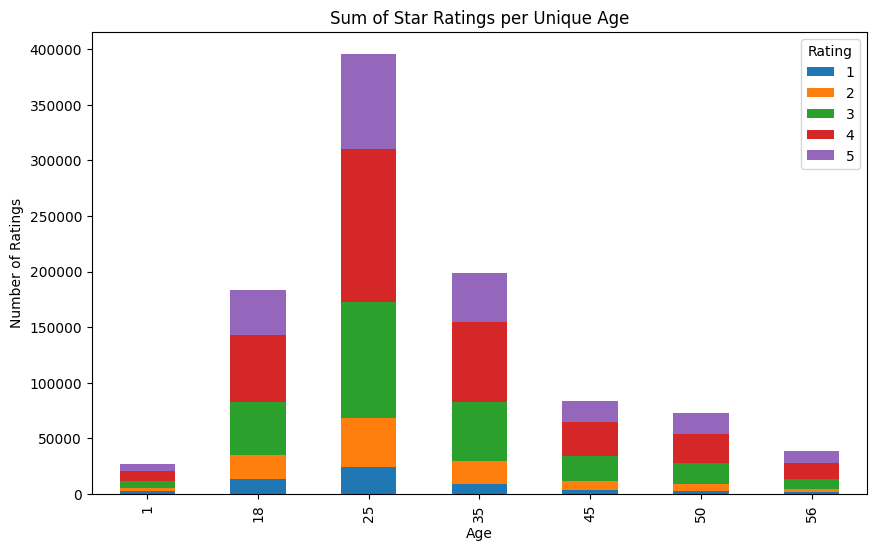

In [52]:
# Group by Age and Rating, then calculate the sum
grouped_data = merged_users.groupby(['User_Age', 'Rating']).size().unstack().fillna(0)

# Print the specific values
print("Sum of Star Ratings per Unique Age:")
print(grouped_data)

# Plot the bar plot
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Age')
plt.ylabel('Number of Ratings')
plt.title('Sum of Star Ratings per Unique Age')

# Show the plot
plt.show()

Sum of Star Ratings per Gender:
Rating           1      2       3       4       5
User_Gender                                      
0            13347  24548   62966   87033   58546
1            42827  83009  198231  261938  167764


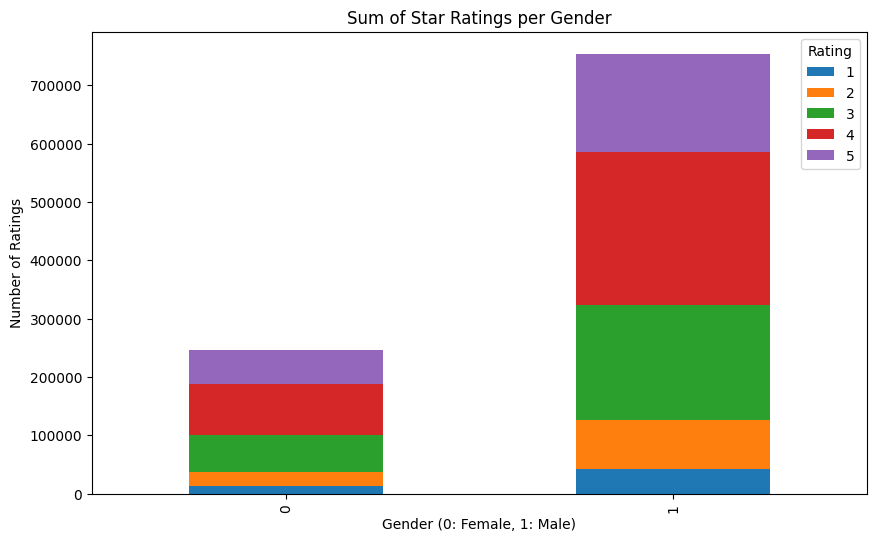

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named merged_df
# If not, you can replace merged_df with your DataFrame name

# Group by Gender and Rating, then calculate the sum
grouped_data_gender = merged_users.groupby(['User_Gender', 'Rating']).size().unstack().fillna(0)

# Print the specific values
print("Sum of Star Ratings per Gender:")
print(grouped_data_gender)

# Plot the bar plot
grouped_data_gender.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Number of Ratings')
plt.title('Sum of Star Ratings per Gender')

# Show the plot
plt.show()

## Checking for Bias with AIF360

In [54]:
print(merged_users['User_Age'].unique())

[ 1 56 25 45 50 35 18]


In [55]:
# # Assuming 'merged_df' is your DataFrame containing the data
# # Choose relevant columns for features and labels
# features = ['Age', 'Gender', 'Occupation']  # Include other relevant features
# label = 'Rating'

# # Split the dataset into training and testing sets
# train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42)

# # Create StandardDatasets for training and testing
# train_dataset = StandardDataset(train_df, label_name=label, favorable_classes=[5],
#                                 protected_attribute_names=['Age'], privileged_classes=[[1]])
# test_dataset = StandardDataset(test_df, label_name=label, favorable_classes=[5],
#                                protected_attribute_names=['Age'], privileged_classes=[[1]])


# # Initialize and train the linear regression model
# lr_model = LinearRegression()
# lr_model.fit(train_dataset.features, train_dataset.labels.ravel())


# # Make predictions on the test set
# test_predictions = lr_model.predict(test_dataset.features)

# # Evaluate the performance (e.g., mean squared error)
# mse = mean_squared_error(test_dataset.labels, test_predictions)
# print("Mean Squared Error:", mse)

# # Calculate the disparate impact before any mitigation
# metric_before = BinaryLabelDatasetMetric(test_dataset, unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
# disparate_impact_before = metric_before.disparate_impact()
# print("Disparate Impact Before Mitigation:", disparate_impact_before)

# # Apply Disparate Impact Remover as a mitigation technique
# di_removal = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='Age')
# test_dataset_transformed = di_removal.fit_transform(test_dataset)

# # Calculate the disparate impact after mitigation
# metric_after = BinaryLabelDatasetMetric(test_dataset_transformed, unprivileged_groups=[{'Age': 0}], privileged_groups=[{'Age': 1}])
# disparate_impact_after = metric_after.disparate_impact()
# print("Disparate Impact After Mitigation:", disparate_impact_after)

### Checking for Bias When Age >= 56

In [56]:
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['User_Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_users, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[lambda x: x >= 56])  # Assuming 56 indicates privileged class

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'User_Age': 0}], privileged_groups=[{'User_Age': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover as a mitigation technique
privileged_groups = [{'User_Age': 1}]
unprivileged_groups = [{'User_Age': 0}]

rw = Reweighing(unprivileged_groups=[{'User_Age': 0}], privileged_groups=[{'User_Age': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 0.8073975893273045
Disparate Impact After Mitigation: 1.0000000000000007


#### Analysis: 
- Privileged Group (Males, Age >= 56)
- Unprivileged Group (Females, Age < 56):
- Disparate Impact Before Mitigation (0.8074):
  - Interpretation: Females (age less than 56) are less likely to give high ratings compared to males (age greater than or equal to 56) before mitigation.

In [57]:
#Now switching underpriviledged group

# Define the protected attributes
protected_attributes = ['User_Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_users, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[lambda x: x >= 56])  # Assuming 56 indicates privileged class

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'User_Age': 1}], privileged_groups=[{'User_Age': 0}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover as a mitigation technique
privileged_groups = [{'User_Age': 0}]
unprivileged_groups = [{'User_Age': 1}]

rw = Reweighing(unprivileged_groups=[{'User_Age': 1}], privileged_groups=[{'User_Age': 0}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.2385471708345885
Disparate Impact After Mitigation: 0.9999999999999992


- Privileged Group (Females, Age >= 56)
- Unprivileged Group (Males, Age < 56):
- Disparate Impact Before Mitigation (1.2437):
  - Interpretation: Males (age less than 56) are more likely to give high ratings compared to females (age greater than or equal to 56) before mitigation.

#### TESTING

In [58]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# Define the protected attributes
protected_attributes = ['User_Gender', 'User_Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_users, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=([1, 1], [25, 25]))

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'User_Gender': 0, 'User_Age': 56}],
                                         privileged_groups=[{'User_Gender': 1, 'User_Age': 25}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Disparate Impact Remover separately for each sensitive attribute
di_removal_gender = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='User_Gender')
di_removal_age = DisparateImpactRemover(repair_level=1.0, sensitive_attribute='User_Age')

dataset_transformed = di_removal_gender.fit_transform(dataset)
dataset_transformed = di_removal_age.fit_transform(dataset_transformed)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'User_Gender': 0, 'User_Age': 56}],
                                        privileged_groups=[{'User_Gender': 1, 'User_Age': 25}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.5808932997581773
Disparate Impact After Mitigation: 1.5808932997581773


Privileged Group (Males, Age = 25)
Unprivileged Group (Females, Age = 1)

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming 'Rating' is the target variable and other columns are features
features = dataset_transformed.features
labels = dataset_transformed.labels.flatten()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Initialize and train the linear regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.1740581653867517


In [60]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# Define the protected attributes
protected_attributes = ['User_Gender','User_Age']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(merged_users, label_name='Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=([1, 1], [25, 25]))

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'User_Gender': 0, 'User_Age': 56}],
                                         privileged_groups=[{'User_Gender': 1, 'User_Age': 25}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'User_Gender': 0, 'User_Age': 56}], privileged_groups=[{'User_Gender': 1, 'User_Age': 25}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'User_Gender': 0, 'User_Age': 56}],
                                        privileged_groups=[{'User_Gender': 1,'User_Age': 25}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)

Disparate Impact Before Mitigation: 1.5808932997581773
Disparate Impact After Mitigation: 1.0000000000000002


In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset_transformed.features, dataset_transformed.labels.flatten(), test_size=0.2)

# Initialize and train the linear regression model on the transformed data
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.17449121171331441
